# Import Dependencies

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

# Import and clean Raw Data

In [15]:
fields = ["building_id", "sub_primaryspaceusage", "sqft", "yearbuilt", "numberoffloors"]
dfm = pd.read_csv("raw/metadata.csv", usecols=fields)
dfm=dfm.set_index('building_id')

dfe = pd.read_csv("raw/electricity_cleaned.csv")
dfe_cleaned = pd.DataFrame(dfe.drop(['timestamp'], axis=1).mean()).reset_index()
dfe_cleaned.columns = ["building_id","power_consumption"]
dfe_cleaned=dfe_cleaned.set_index("building_id")

data = pd.merge(dfm, dfe_cleaned, left_index=True, right_index=True).reset_index()

weather = ["site_id", "airTemperature", "dewTemperature"]
dfw = pd.read_csv("raw/weather.csv", usecols=weather)

dfw_mean = dfw.groupby("site_id").mean()
dfw_mean.reset_index()

data['site_id'] = data['building_id'].apply(lambda x: x.split('_')[0])
merged_df = pd.merge(data, dfw_mean, on='site_id', how='left')

def calculate_relative_humidity(air_temp, dew_temp):
    numerator = np.exp((17.625 * dew_temp) / (dew_temp + 243.04))
    denominator = np.exp((17.625 * air_temp) / (air_temp + 243.04))
    humidity = 100 * (numerator / denominator)
    return humidity

merged_df['humidity'] = calculate_relative_humidity(merged_df['airTemperature'], merged_df['dewTemperature'])

final_df = merged_df.drop(["building_id", "site_id", "dewTemperature"], axis = 1)

new_column_order = ['sub_primaryspaceusage', 'sqft', 'yearbuilt', 'numberoffloors', 'airTemperature', "humidity", 'power_consumption']

final_df = final_df[new_column_order]

final_df.columns = ['building_type', 'sqft', 'yearbuilt', 'numberoffloors', 'airTemperature', "humidity", 'power_consumption']

final_df = final_df[final_df['power_consumption'].notna()]

no_na = final_df.dropna()

final_df

,building_type,sqft,yearbuilt,numberoffloors,airTemperature,humidity,power_consumption
0,Research,7432.0,2008.0,NaN,22.805091,70.951442,64.977761
1,Research,2720.0,2004.0,NaN,22.805091,70.951442,33.433645
2,Classroom,5376.0,1991.0,NaN,22.805091,70.951442,6.687316
3,Classroom,23685.0,2002.0,NaN,22.805091,70.951442,89.617149
4,Research,116607.0,1975.0,NaN,22.805091,70.951442,417.137948
...,...,...,...,...,...,...,...
1573,Hospital,185064.0,1936.0,10.0,11.842307,75.574163,384.684218
1574,Hospital,58114.0,1954.0,6.0,11.842307,75.574163,43.587324
1575,Hospital,18826.0,NaN,8.0,11.842307,75.574163,17.679361
1576,Hotel,37555.0,2006.0,7.0,11.842307,75.574163,45.767561


In [18]:
no_na

,building_type,sqft,yearbuilt,numberoffloors,airTemperature,humidity,power_consumption
107,College Classroom,97532.0,2005.0,10.0,11.842307,75.574163,167.111574
108,College Laboratory,81580.0,1913.0,5.0,11.842307,75.574163,250.585169
109,College Laboratory,56995.0,1953.0,6.0,11.842307,75.574163,255.110121
110,College Laboratory,27814.0,2006.0,8.0,11.842307,75.574163,286.843880
111,College Laboratory,118338.0,1909.0,7.0,11.842307,75.574163,403.121800
...,...,...,...,...,...,...,...
1572,Hospital,190898.0,2012.0,10.0,11.842307,75.574163,783.350343
1573,Hospital,185064.0,1936.0,10.0,11.842307,75.574163,384.684218
1574,Hospital,58114.0,1954.0,6.0,11.842307,75.574163,43.587324
1576,Hotel,37555.0,2006.0,7.0,11.842307,75.574163,45.767561


# Fit Gaussian Copula 

In [19]:
LOAD = False
EPOCHS = 10000
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(no_na) 

if LOAD:
    synthesizer = GaussianCopulaSynthesizer.load(filepath="models/gen_model.pkl")
else:
    synthesizer = GaussianCopulaSynthesizer(
        metadata,
        enforce_rounding=True,
        enforce_min_max_values=False,
        default_distribution='gaussian_kde',
    )

    sqft_r = {
        'constraint_class': 'ScalarRange',
        'constraint_parameters': {
            'column_name': 'sqft',
            'low_value': final_df['sqft'].min(),
            'high_value': final_df['sqft'].max(),
            'strict_boundaries': False
        }
    }

    numberoffloors_r = {
        'constraint_class': 'ScalarRange',
        'constraint_parameters': {
            'column_name': 'numberoffloors',
            'low_value': 1,
            'high_value': 100,
            'strict_boundaries': False
        }
    }

    yearbuilt_r = {
        'constraint_class': 'ScalarRange',
        'constraint_parameters': {
            'column_name': 'yearbuilt',
            'low_value': final_df['yearbuilt'].min(),
            'high_value': final_df['yearbuilt'].max(),
            'strict_boundaries': False
        }
    }
        
    power_r = {
        'constraint_class': 'Positive',
        'constraint_parameters': {
            'column_name': 'power_consumption',
            'strict_boundaries': True
        }
    }

    synthesizer.add_constraints(
    constraints=[sqft_r, numberoffloors_r, yearbuilt_r, power_r]
    )
    synthesizer.fit(no_na)

C:\Users\raaja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


# Evaluation

In [20]:
SAMPLES = 300

samples = synthesizer.sample(
    num_rows=SAMPLES,
    batch_size=10
)
samples

Sampling rows: 100%|████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 163.92it/s]


,building_type,sqft,yearbuilt,numberoffloors,airTemperature,humidity,power_consumption
0,Community Center,10781.0,1925.0,2.0,10.855513,81.806065,1.921181
1,Education,45179.0,1945.0,6.0,15.361142,83.782321,61.447535
2,Education,94566.0,1933.0,5.0,11.513358,73.086583,166.385620
3,Hospital,28377.0,1905.0,5.0,15.217176,75.722808,12.269820
4,Primary/Secondary Classroom,96252.0,1996.0,2.0,11.732339,81.498620,33.667852
...,...,...,...,...,...,...,...
295,Community Center,3490.0,1983.0,2.0,11.402991,83.222784,2.442642
296,College Classroom,56374.0,1922.0,14.0,14.794320,66.809286,28.716382
297,Laboratory,120151.0,1970.0,1.0,10.864507,85.773226,76.977225
298,Primary/Secondary Classroom,189693.0,1994.0,4.0,11.412624,78.745232,79.978364


In [21]:
eval_real = no_na.copy()
eval_fake = samples.copy()

le = LabelEncoder()
eval_real['building_type'] = le.fit_transform(eval_real['building_type'])
eval_fake['building_type'] = le.fit_transform(eval_fake['building_type'])

(eval_real['sqft'] < 0).sum()

0

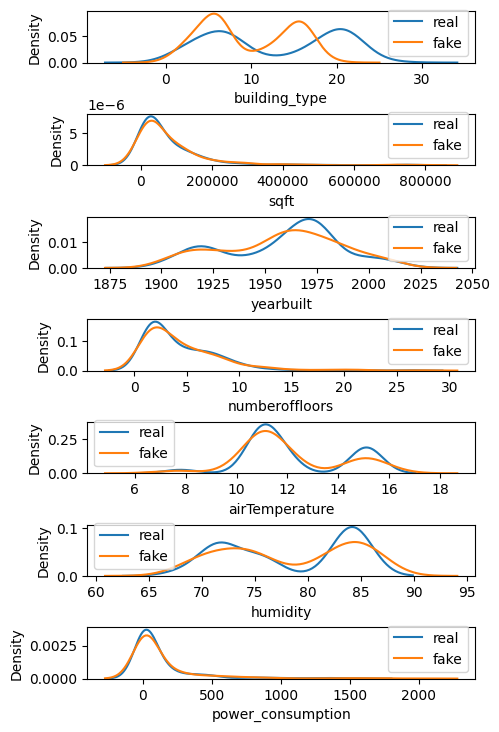

In [22]:
fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(hspace=1, wspace=0.4)

for n,cat in enumerate(eval_real.columns):
    ax = fig.add_subplot(8, 1, n+1)
    sns.kdeplot(eval_real[cat], label = 'real', ax=ax)
    sns.kdeplot(eval_fake[cat], label = 'fake', ax = ax)
    plt.legend()

<Axes: >

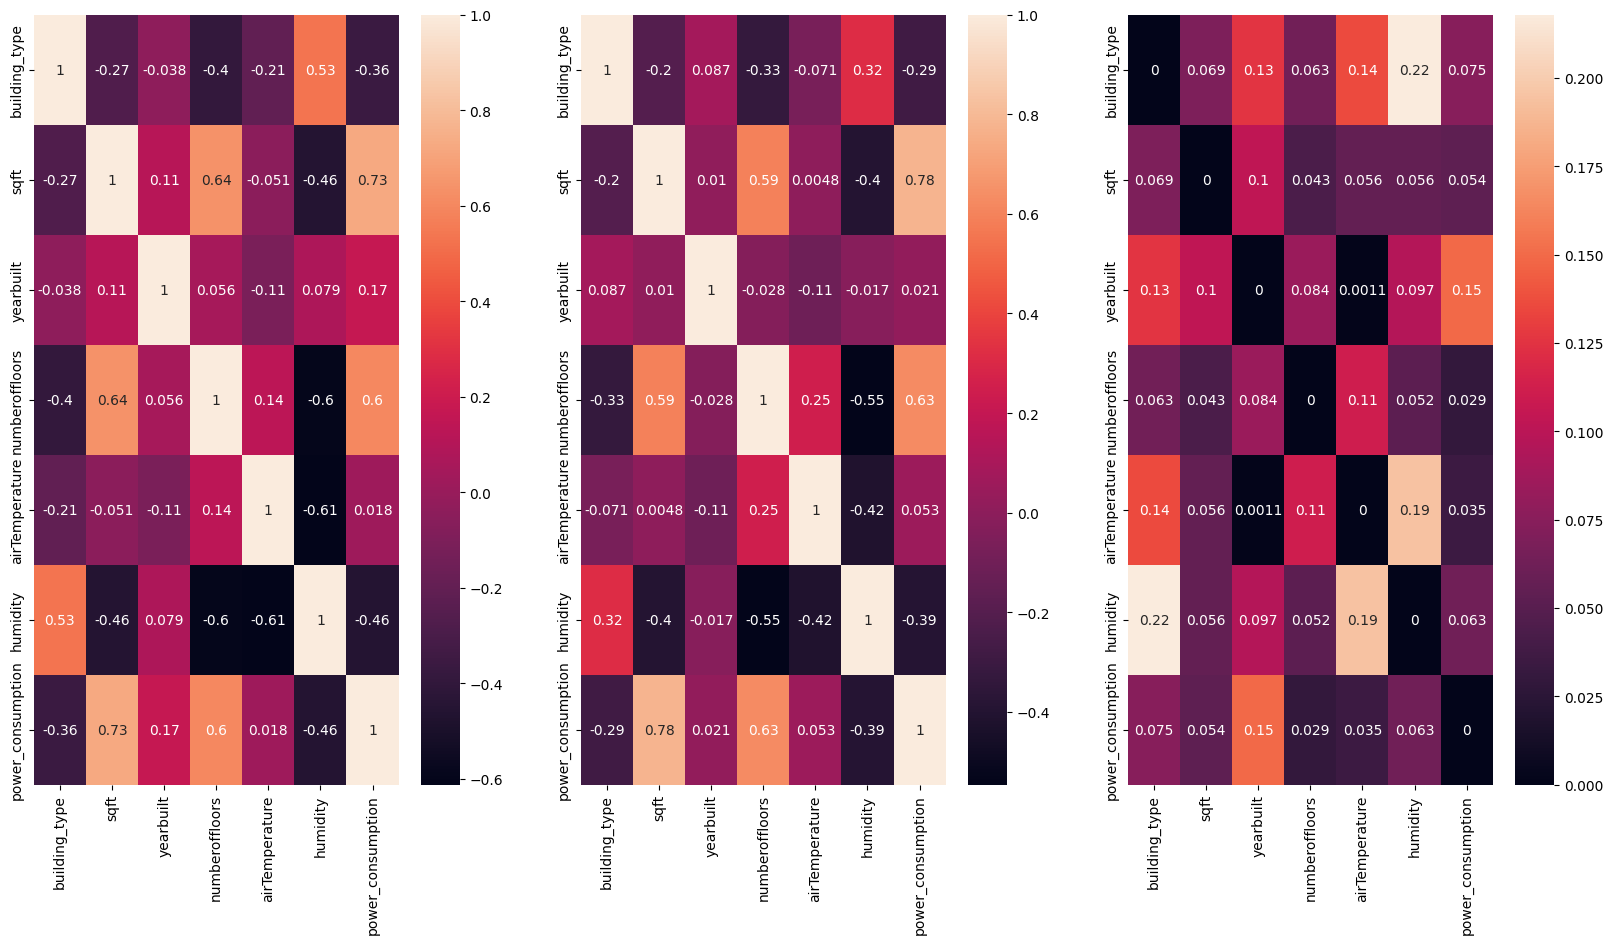

In [28]:
fig_corr = plt.figure(figsize=(20,10))
ax = fig_corr.add_subplot(1, 3, 1)
sns.heatmap(eval_real.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(1, 3, 2)
sns.heatmap(eval_fake.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(1, 3, 3)
sns.heatmap(abs(eval_real.corr()-eval_fake.corr()), annot=True, ax=ax)

# Reconstructing missing data

In [24]:
final_df.isnull().sum(axis = 0)

building_type          19
sqft                    0
yearbuilt             798
numberoffloors       1135
airTemperature          0
humidity                0
power_consumption       0
dtype: int64

In [25]:
na_lst = ['building_type','yearbuilt','numberoffloors']

for it in na_lst:
    final_df.loc[final_df[it].isna(), it] = synthesizer.sample_remaining_columns(
    known_columns=final_df.loc[final_df[it].isna()].drop(['building_type','yearbuilt','numberoffloors'], axis=1),
    max_tries_per_batch=100
    )[it]

final_df.isnull().sum(axis = 0)

Sampling remaining columns: 100%|██████████████████████████████████████████████████| 1135/1135 [00:49<00:00, 23.10it/s]


building_type        0
sqft                 0
yearbuilt            0
numberoffloors       0
airTemperature       0
humidity             0
power_consumption    0
dtype: int64

# Saving Result

In [26]:
final_df.index.name = 'building_id'
final_df.to_csv("real_data.csv")

In [27]:
synthesizer.save(filepath="models/gen_model.pkl")